[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorial_notebooks/7_deep_learning.ipynb)

# Tutorial 9 - Tree-based Algorithms for Predictive Modeling
This notebook revisits our lecture on tree learning algorithms. We begin with regression decision trees suitable for the estimation of continuous target variables. Thereafter, we cover classification trees. The exercises in this notebook are concerned with the implementation of tree algorithms using *Sklearn*, and their visualization.

In [90]:
# Standard imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Decision Trees Demo

### Regression Trees

Let's begin with revisiting regression decision trees. Before we move on to algorithmic details, we will cover two simple regression problems in order to highlight when it makes sense to apply decision trees. These examples illustrate how the nature of the relationship between the input feature and the target variable influences the choice of the predictive model.<br>

**Example 1: Linear Feature–Target Relationship**

Consider the task of predicting the resale price of a product based on its age, i.e., amount of months being used. In the first example, the data exhibits a clear and approximately linear trend: resale prices decrease as the product becomes older, and each additional month of age reduces the price by roughly the same amount.

In such settings, the relationship between the input feature (age) and the target variable (resale price) can be well approximated by a straight line. Linear regression is therefore a suitable and effective modeling choice. It captures the global trend in the data, is easy to interpret, and typically yields small residuals when the linearity assumption holds. This example highlights an important principle: when the feature–target relationship is approximately linear, simple linear models are often sufficient and preferable due to their simplicity and transparency.


<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/Tree_Notebook_Linear_Example.PNG" alt="NN as a directed graph" width="620" />
</p>

**Example 2: Nonlinear Feature–Target Relationship**

Now consider a second scenario involving the same variables, but where the relationship between age and resale price is no longer linear. Although resale prices still tend to decrease with age, the decrease is not uniform. Instead, the data exhibits jumps and regime changes: the impact of an additional month of age varies depending on the current age of the product.

In such cases, a linear model struggles to represent the underlying structure of the data. A single straight line cannot adequately capture discontinuities or varying rates of change, resulting in larger residuals and poorer predictive performance. This motivates the use of nonlinear models that can adapt to more complex feature–target relationships.

<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/Tree_Notebook_Nonlinear_Example.PNG" alt="NN as a directed graph" width="620" />
</p>

Decision trees are well suited for such situations. They work by splitting the feature space into smaller regions and making simple predictions—a constant value—within each region. This enables them to model nonlinear relationships and regime changes in the data, while still remaining easy to interpret. Therefore, in the remainder of this section, we will cover decision tree learning in detail.<br><br>

**Example 3: Grown Decision Tree producing a total of four distinctive Predictions**<br>

Having motivated the use of decision trees as nonlinear models, we now turn to a concrete example of a grown regression tree. The example below illustrates how a decision tree represents nonlinear relationships by recursively partitioning the feature space into four main regions.<br>

The figure shows a regression tree trained on the resale price data using age as the only input feature. The tree performs a sequence of binary splits on age, dividing the data into four subsets. Each subset corresponds to a leaf node of the tree. Within each leaf node, the model outputs a single prediction, which is computed as the average resale price of all training samples that fall into that leaf. As a result, the tree produces exactly one prediction per leaf node.

When a new data point is evaluated, it is routed through the tree according to the split conditions until it reaches a leaf node. The predicted resale price is then given by the value associated with that leaf. Consequently, a tree with four leaf nodes can output only four distinct prediction values, regardless of the input age.

<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/Tree_Notebook_Four_Leaf_Nodes_Example.PNG" alt="NN as a directed graph" width="720" />
</p>

Having examined how a fully grown regression tree generates predictions, we now turn to the principles underlying its construction. The learning process can be understood as a greedy, top-down procedure that incrementally builds the tree by making locally optimal decisions at each node. The pseudo-code below summarizes the main steps in the training process of a regression decision tree.

<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/Tree_Notebook_Pseudo_Code.PNG" alt="NN as a directed graph" width="620" />
</p>

At each step of the tree-building process, the algorithm aims to split the data so that predictions become more accurate. To do so, it evaluates possible splits by assessing how much they reduce the prediction error, i.e., the total sum of squared residuals (SSR), compared to leaving the data unsplit. This optimization is performed independently at each node, without revisiting earlier decisions. As a result, the final tree structure reflects a sequence of locally optimal choices. The tree growth proceeds until a predefined stopping condition is met.<br>

The training strategy illustrates both the flexibility and the limitations of decision trees: while they can model complex nonlinear relationships, their greedy nature makes them sensitive to data fluctuations and prone to overfitting if left unconstrained. These considerations motivate the use of regularization techniques such as pre- and post pruning. The former involves for instance setting the maximum tree depth before the training process has began. In contrast, with post pruning the decision tree is grown to its full extend, and leaf nodes are merged ex post.

### Classification Trees

Having established how regression trees determine splits by minimizing a regression loss function such as SSR, we now turn to classification trees, where the prediction target is categorical rather than numeric. While the recursive, greedy structure of the learning algorithm remains unchanged, the criterion used to evaluate candidate splits must be adapted to reflect the different nature of the prediction task.

In a classification setting, the goal is no longer to reduce the prediction error measured in squared deviations, but instead to increase the purity of the resulting nodes—that is, to create subsets of the data that are as homogeneous as possible with respect to the class labels. Each potential split is therefore assessed by how well it separates observations into groups dominated by a single class. This is achieved by replacing SSR with impurity-based measures, which quantify the degree of class mixing within a node.

Common impurity measures include the **gini index** and **entropy**, both of which attain their minimum when all observations in a node belong to the same class and their maximum when classes are evenly mixed. The reduction in impurity achieved by a split— referred to as **information gain**—plays a role directly analogous to the reduction in SSR in regression trees. As before, the algorithm evaluates all candidate splits for each feature, selects the split that yields the largest impurity reduction, and applies this decision locally at the current node.<br>

Given the importance of information gain in growing classification trees, in the following we will revisit its computation:<br>

<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/Tree_Notebook_Classification_Node_Splitting.PNG" alt="NN as a directed graph" width="620" />
</p>

Next, we will import the already preprocessed HMEQ dataset, and will use the feature DEBTINC to identify potential splitting thresholds for the computation of gini-based and entropy-based information gain.

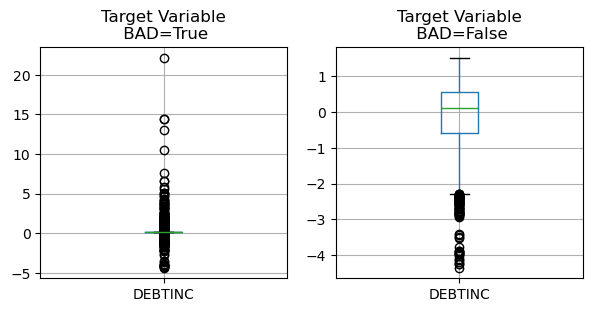

In [ ]:
#Import the preprocessed HMEQ dataset:
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv'
df = pd.read_csv(data_url)

#Take the feature DEBTINC (debt-to-income) and calculate the entropy and gini impurity for different splits.
#Plot the distribution of DEBTINC for the two classes in the target variable to decide which splitting thresholds to test:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(7,3))
df[df['BAD']==True][['DEBTINC']].boxplot(ax=ax[0])
ax[0].set_title('Target Variable\n BAD=True')
df[df['BAD']==False][['DEBTINC']].boxplot(ax=ax[1])
ax[1].set_title('Target Variable\n BAD=False')

plt.show()
plt.close()

Based on the distribution of DEBTINC with respect to each target class, we select the two thresholds [2.0, -1.0] to compute the entropy-based and gini-based impurity as well as the resulting information gains. The conditional boxplots indicate that the threshold 2.0 likely results in more accurate predictions than the threshold -1.0, since values of DEBTINC>2.0 are associated with BAD=True cases only. Now, let's see whether computing the information gain would lead to the same conclusion. 

In [118]:
thresholds=[2.0,-1.0]

#Computation of class probabilities in the root node before the split:
root_node_proba_pos=df[df['BAD']==True].shape[0]/df.shape[0]
root_node_proba_neg=df[df['BAD']==False].shape[0]/df.shape[0]

#Computation of entropy and gini for the root node:
root_node_entropy=-1*(root_node_proba_pos*np.log2(root_node_proba_pos)+root_node_proba_neg*np.log2(root_node_proba_neg))
root_node_gini=1.0-(root_node_proba_pos**2 + root_node_proba_neg**2)


for threshold in thresholds:
    left_node_samples=df[df['DEBTINC']<=threshold][['BAD']]
    left_node_proba=left_node_samples.shape[0]/df.shape[0]
    right_node_samples=df[df['DEBTINC']>threshold][['BAD']]
    right_node_proba=right_node_samples.shape[0]/df.shape[0]

    #Computation of class probabilities after split:
    left_node_proba_pos=left_node_samples[left_node_samples['BAD']==True].shape[0]/left_node_samples.shape[0]
    left_node_proba_neg=left_node_samples[left_node_samples['BAD']==False].shape[0]/left_node_samples.shape[0]

    right_node_proba_pos=right_node_samples[right_node_samples['BAD']==True].shape[0]/right_node_samples.shape[0]
    right_node_proba_neg=right_node_samples[right_node_samples['BAD']==False].shape[0]/right_node_samples.shape[0]


    #Computation of entropy and resulting information gain:
    left_node_entropy=-1*((left_node_proba_pos*np.log2(left_node_proba_pos) if left_node_proba_pos!=0.0 else 0.0)+(left_node_proba_neg*np.log2(left_node_proba_neg) if left_node_proba_neg!=0.0 else 0.0))
    right_node_entropy=-1*((right_node_proba_pos*np.log2(right_node_proba_pos) if right_node_proba_pos!=0.0 else 0.0) + (right_node_proba_neg*np.log2(right_node_proba_neg) if right_node_proba_neg!=0.0 else 0.0))
    ig_entropy=root_node_entropy-left_node_proba*left_node_entropy-right_node_proba*right_node_entropy

    #Computation of gini and resulting information gain:
    left_node_gini=1.0-(left_node_proba_pos**2 + left_node_proba_neg**2)
    right_node_gini=1.0-(right_node_proba_pos**2 + right_node_proba_neg**2)
    ig_gini=root_node_gini-left_node_proba*left_node_gini-right_node_proba*right_node_gini

    print('--------------------------------------------------')
    print('Testing Threshold: ',threshold)
    print('Entropy estimates and resulting Information Gain: ')
    print(' - Entropy of Left Node after Split: ',round(left_node_entropy,3))
    print(' - Entropy of Right Node after Split: ',round(right_node_entropy,3))
    print(' - Information Gain using Entropy: ',round(ig_entropy,3),'\n')

    print('Gini estimates and resulting Information Gain: ')
    print(' - Gini of Left Node after Split: ',round(left_node_gini,3))
    print(' - Gini of Right Node after Split: ',round(right_node_gini,3))
    print(' - Information Gain using Gini: ',round(ig_gini,3),'\n')


--------------------------------------------------
Testing Threshold:  2.0
Entropy estimates and resulting Information Gain: 
 - Entropy of Left Node after Split:  0.708
 - Entropy of Right Node after Split:  -0.0
 - Information Gain using Entropy:  0.019 

Gini estimates and resulting Information Gain: 
 - Gini of Left Node after Split:  0.312
 - Gini of Right Node after Split:  0.0
 - Information Gain using Gini:  0.01 

--------------------------------------------------
Testing Threshold:  -1.0
Entropy estimates and resulting Information Gain: 
 - Entropy of Left Node after Split:  0.337
 - Entropy of Right Node after Split:  0.76
 - Information Gain using Entropy:  0.016 

Gini estimates and resulting Information Gain: 
 - Gini of Left Node after Split:  0.117
 - Gini of Right Node after Split:  0.343
 - Information Gain using Gini:  0.006 



As we suspected, the information gain using both gini and entropy is higher when using the threshold 2.0 in comparison to -1.0. This results mostly from the lower impurity estimates of entropy and gini of the right node samples.

# Exercises

**Shallow Decision Tree**
- import decision tree classifier, the function for train-test splitting and the function for computing AUC score from *Sklearn*
- split your data into train and test data (70:30) using the random seed = 123
- implement a decision tree with the following configuration: 
    - maximum depth of the tree = 3
    - number of features to consider for finding the best split = square root of dataset attributes
    - random seed of decision tree = 123
- evaluate the predictions with the AUC score from sklearn

In [119]:
# Space for your solution


**Visualization of trained Decision Trees**
- import the function for plotting a decision tree
- split your data into train and test subsets (70:30) using the following random seeds: 123, 952 and 1063
- in a loop, train a decision tree on each train test split associated with one of the random seeds. Use the tree model configuration from the previous exercise for all random seeds.
- visualize the structure of the decision trees in the loop. Why do we observe differences in the trained decision trees? What are the main conclusions concerning feature importances we draw from the visualized tree structures?

In [ ]:
# Space for your solution
